### This test is to explore the small difference between atomic and non-atomic SIR simulation results

> If not atomic:it’s like we always spread in order. For a susceptible node, every infected node before it would help infect it. So It would speed up the spreading of disease. But meanwhile, once nodes get infected, they start to recover. 

> It turns out that it's hard to tell the difference between atomic and non-atomic SIR results.

In [1]:
import networkx as nx
import operator #standard python library used for sorting
from tqdm import tqdm
import random
from utils.timing import timeit
from utils.fileload import load_matfile
import matplotlib.pyplot as plt

In [2]:
G_blogcatalog = load_matfile(file_ = "blogcatalog.mat",unDirected=True)

In [3]:
State = {'susceptible': 0, 
         'infectious' : 1, 
         'removed'    : 2}


def reset(G):
    '''
    set all nodes' state as 'susceptible'
    '''
    nx.set_node_attributes(G, name = 'state', values = State['susceptible'])
    
def nodes_sorted(G, sort_by_attribute = "degree"):
    '''
    return sort nodes by attribute e.g. degree/betweenness
    '''
    if sort_by_attribute == "degree":
        node_attributes = dict(G.degree())
    elif sort_by_attribute == "betweenness":
        node_attributes = dict(nx.betweenness_centrality(G))
    sorted_nodes = dict(sorted(node_attributes.items(), key=operator.itemgetter(1), reverse=True))
    return sorted_nodes

def set_seeds(G, num_seeds, set_seeds_by = "degree"):
    '''
    select seeds by random or degree,
    set seeds' state as infected
    '''
    if set_seeds_by == "degree":
        seeds = list(nodes_sorted(G, sort_by_attribute="degree").keys())[0:num_seeds]
    elif set_seeds_by == "random":
        seeds = random.sample(list(G.nodes), num_seeds)
        
    for seed in seeds:
        G.node[seed]['state'] = State['infectious']
    return seeds

In [4]:
def model_factory(beta, alpha, is_atomic):
    '''
    model_atomic updates states all at once;
    model_non_atomic updates states one by one
    return a SIR spreading simulation model
    '''
    def model_atomic(n, G):
        neighbors_to_infect = []
        RemoveMyself = False
        if G.node[n]['state'] == State['infectious']:
            susceptible_neighbors = [k for k in G.neighbors(n) if G.node[k]['state']==State['susceptible']]
            for k in susceptible_neighbors:
                if random.random() < beta:
                    neighbors_to_infect.append(k)
            if random.random() < alpha:
                RemoveMyself = True
        return neighbors_to_infect, RemoveMyself
    
    def model_non_atomic(n, G):
        if G.node[n]['state'] == State['infectious']:
            for k in G.neighbors(n):
                if G.node[k]['state'] == State['susceptible']:
                    if random.random() <= beta:
                        G.node[k]['state'] = State['infectious']
            if random.random() <= alpha:
                G.node[n]['state'] = State['removed']  
                
    if is_atomic == True:
        model = model_atomic
    else:
        model = model_non_atomic
    return model
        

def one_epoch(G, model):
    '''
    add all nodes to be infected to nodes_to_infect,
    add all nodes to be removed to nodes_to_remove,
    and update their states all at once
    '''
    nodes_to_infect = []
    nodes_to_remove = []
    for n in G:
        neighbors_to_infect, RemoveMyself = model(n, G)
        nodes_to_infect += neighbors_to_infect
        nodes_to_remove += [n] if RemoveMyself else []
        
    for n in nodes_to_infect:
        G.node[n]['state'] = State['infectious']
    for n in nodes_to_remove:
        G.node[n]['state'] = State['removed']
    
def get_states(G):
    susceptible_nodes = []
    infected_nodes = []
    removed_nodes = []
    for n in G:
        state = G.node[n]['state']
        if state == State['susceptible']:
            susceptible_nodes.append(n)
        elif state == State['infectious']:
            infected_nodes.append(n)
        elif state == State['removed']:
            removed_nodes.append(n)
    return susceptible_nodes, infected_nodes, removed_nodes

@timeit
def spread(G, model, is_atomic):
    ss, ii, rr = [], [], []
    i = 1 # anything > 0 to enter the loop below
    while(i > 0):
        susceptible_nodes, infected_nodes, removed_nodes = get_states(G)
        i = len(infected_nodes)
        print('\r num_infectious_nodes:         %d' % (i),end="")
        ss.append(len(susceptible_nodes))
        ii.append(i)
        rr.append(len(removed_nodes))
        
        if is_atomic:
            one_epoch(G, model)
        else:
            for n in G:
                model(n, G)
        
    return ss, ii, rr

In [5]:
# G_FB = nx.read_edgelist("NOLAfacebook.csv", create_using=nx.Graph(), delimiter=",", nodetype=int)
# print("Graph readed!")

 num_infectious_nodes:         0015'spread'  14616.33 ms


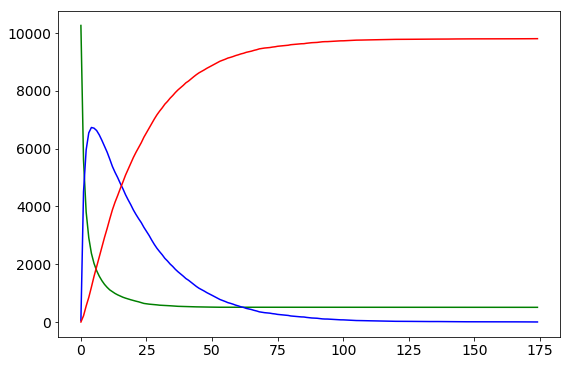

In [6]:
reset(G_blogcatalog)
set_seeds(G=G_blogcatalog, num_seeds=50, set_seeds_by="degree")
model = model_factory(beta=0.03, alpha=0.05, is_atomic=False)
ss, ii, rr = spread(G_blogcatalog, model, is_atomic=False)

fig_size= [9,6]
plt.rcParams.update({'font.size': 14, "figure.figsize": fig_size})
xvalues = range(len(ss))
plt.plot(xvalues, ss, color='g', linestyle='-', label="S")
plt.plot(xvalues, ii, color='b', linestyle='-', label="I")
plt.plot(xvalues, rr, color='r', linestyle='-', label="R")
plt.show()

 num_infectious_nodes:         0'spread'  15375.71 ms


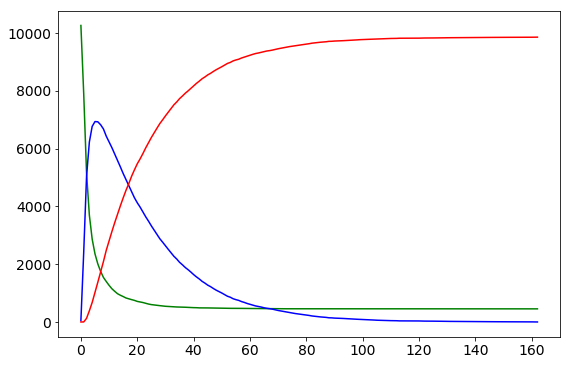

In [7]:
reset(G_blogcatalog)
set_seeds(G=G_blogcatalog, num_seeds=50, set_seeds_by="degree")
model = model_factory(beta=0.03, alpha=0.05, is_atomic=True)
ss, ii, rr = spread(G_blogcatalog, model, is_atomic=True)

fig_size= [9,6]
plt.rcParams.update({'font.size': 14, "figure.figsize": fig_size})
xvalues = range(len(ss))
plt.plot(xvalues, ss, color='g', linestyle='-', label="S")
plt.plot(xvalues, ii, color='b', linestyle='-', label="I")
plt.plot(xvalues, rr, color='r', linestyle='-', label="R")
plt.show()